In [91]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

### Constants

In [121]:
# Mass
m = 0.035

# Principle moments of inertia
J_x = 1.57e-05
J_y = 1.60e-05
J_z = 2.05e-05
J_in1 = sym.diag(J_x, J_y, J_z)


# Acceleration of gravity
g = 9.81

# # Pendulum parameters
l_pen = 1020e-3 # maybe m
m_pen = 0.011

In [122]:
def Rotate(alpha, beta, gamma):
    Rz = sym.Matrix([[sym.cos(alpha), -sym.sin(alpha), 0],
                 [sym.sin(alpha), sym.cos(alpha), 0],
                 [0, 0, 1]])

    Ry = sym.Matrix([[sym.cos(beta), 0, sym.sin(beta)],
                 [0, 1, 0],
                 [-sym.sin(beta), 0, sym.cos(beta)]])

    Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(gamma), -sym.sin(gamma)],
                 [0, sym.sin(gamma), sym.cos(gamma)]])

    R_VtoO = Rz * Ry * Rx

    return R_VtoO

def N_func(alpha, beta, gamma):
    Ninv = sym.Matrix([[sym.cos(beta)*sym.cos(gamma), -sym.sin(gamma), 0],
                       [sym.cos(beta)*sym.sin(gamma), sym.cos(gamma), 0],
                       [-sym.sin(beta), 0, 1]])

    # N = sym.simplify(Ninv.inv())
    N = Ninv.inv()
    return N

### State Derivative

Calculates the derivative of the state.

In [123]:
def propogate_state(state, inputs):
    # state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz, r, s, rdot, sdot]
    # state: [o_x, vx, o_y, vy, o_z, vz, alpha, beta, gamma, wx, wy, wz, r, s, rdot, sdot]
    # state_dot: [o_x_dot, vx_dot, o_y_dot, vy_dot, o_z_dot, vz_dot, alpha_dot, beta_dot, gamma_dot, wx_dot, wy_dot, wz_dot, r_dot, s_dot, r_ddot, s_ddot]

    # inputs: [tau_x, tau_y, tau_z, f_z]
    Rotation_matrix = Rotate(state[6], state[7], state[8])
    N = N_func(state[6], state[7], state[8])
    # second_derivatives = Rotation_matrix * sym.Matrix([0, 0, inputs[3]])/m + sym.Matrix([0, 0, -g])
    angle_derivatives = N * sym.Matrix([state[9], state[10], state[11]]) # [gamma_dot, beta_dot, alpha_dot]
    f_in1 = Rotation_matrix.T * sym.Matrix([0, 0, -(m + m_pen) * g]) + sym.Matrix([0, 0, inputs[3]])
    tau_in1 = sym.Matrix([inputs[0], inputs[1], inputs[2]])
    w_01in1 = sym.Matrix([state[9], state[10], state[11]])
    w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
    zeta = np.sqrt(l_pen**2 - state[12]**2 - state[13]**2)
    state_dot = np.zeros(16)
    
    # NEW CHANGES
    v_01in1 = sym.Matrix([state[1], state[3], state[5]])
    o_dot = Rotation_matrix @ v_01in1 # o_dot matrix in terms of vx,vy,vz
    v_dot = (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1))
    o_ddot = Rotation_matrix @ v_dot

    # vx, vy, vz (state) --> oxdot, oydot, ozdot (calculate)
    # oxddot, oyddot, ozddot (second derivatives) --> vxdot, vydot, vzdot (calcul)
    state_dot[0] = o_dot[0]
    state_dot[1] = v_dot[0]
    state_dot[2] = o_dot[1]
    state_dot[3] = v_dot[1]
    state_dot[4] = o_dot[2]
    state_dot[5] = v_dot[2]
    state_dot[6] = angle_derivatives[2]
    state_dot[7] = angle_derivatives[1]
    state_dot[8] = angle_derivatives[0]
    state_dot[9] = w_derivatives[0]
    state_dot[10] = w_derivatives[1]
    state_dot[11] = w_derivatives[2]
    state_dot[12] = state[14]
    state_dot[13] = state[15]
    r = state[12]
    rd = state[14]
    s = state[13]
    sd = state[15]
    xdd = o_ddot[0] # UPDATED
    ydd = o_ddot[1] # UPDATED
    state_dot[15] = (g*l_pen**2*s*zeta - g*r**2*s*zeta - g*s**3*zeta - l_pen**4*ydd + l_pen**2*xdd*r*s + l_pen**2*ydd*r**2 + 2*l_pen**2*ydd*s**2 + l_pen**2*ydd*s*zeta - l_pen**2*rd**2*s - l_pen**2*s*sd**2 - xdd*r**3*s - xdd*r*s**3 - ydd*r**2*s**2 - ydd*r**2*s*zeta - ydd*s**4 - ydd*s**3*zeta + r**2*s*sd**2 - 2*r*rd*s**2*sd + rd**2*s**3)/((r**2 - l_pen**2)*(s**2 - l_pen**2))
    state_dot[14] = (g*l_pen**2*r*zeta - g*s**2*r*zeta - g*r**3*zeta - l_pen**4*xdd + l_pen**2*ydd*r*s + l_pen**2*xdd*s**2 + 2*l_pen**2*xdd*r**2 + l_pen**2*ydd*r*zeta - l_pen**2*rd**2*r - l_pen**2*r*sd**2 - ydd*r**3*s - ydd*r*s**3 - xdd*r**2*s**2 - ydd*s**2*r*zeta - xdd*r**4 - ydd*r**3*zeta + s**2*r*rd**2 - 2*s*sd*r**2*rd + sd**2*r**3)/((r**2 - l_pen**2)*(s**2 - l_pen**2))

    return state_dot

### RK4 propogator

To get the next state

In [124]:
def rk4(state, inputs, delta_t):
    y1 = propogate_state(state, inputs)
    y2 = propogate_state(state + 1/2*delta_t*y1, inputs)
    y3 = propogate_state(state + 1/2*delta_t*y2, inputs)
    y4 = propogate_state(state + delta_t*y3, inputs)

    return state + 1/6 * delta_t *(y1 + 2*y2 + 2*y3 + y4)


### Controller

To calculate the inputs based on the current state. The K values are from the `controller_design_body_vel.ipynb` notebook.

In [126]:
def controller(state, state_des):
    K = np.array([[-6.17737039e-14, -4.95042886e-14,  4.47213595e-03,
         4.36930478e-03,  4.14156508e-17,  6.09227844e-17,
        -1.42486209e-16,  3.99161053e-14,  1.03152527e-02,
         5.97689106e-04,  6.59116446e-16,  6.99584345e-17,
        -6.07893048e-13,  8.62435385e-02, -1.09694080e-13,
         1.55767705e-02],
       [-4.47213595e-03, -4.37351999e-03, -1.18548340e-14,
        -3.26871538e-16,  1.34704402e-17,  4.38367374e-17,
         6.10320278e-16,  1.04060895e-02,  1.51976715e-14,
         6.46758013e-16,  6.05250526e-04, -1.79386450e-16,
        -8.66537157e-02,  8.80865500e-14, -1.56508507e-02,
         1.59578306e-14],
       [ 5.68858356e-15,  5.02552383e-15,  1.08573681e-14,
         5.19714343e-15,  2.53564216e-18,  7.95018271e-18,
         1.82574186e-04, -4.40944014e-15,  2.28408224e-15,
         5.35779230e-17, -1.40008937e-16,  2.02036816e-04,
         6.37036375e-14,  5.05120514e-14,  1.14800316e-14,
         9.12282157e-15],
       [-8.21623337e-14, -6.52389654e-14,  1.41001627e-13,
         1.11946966e-13,  5.77350269e-02,  9.29782545e-02,
         1.84703329e-15,  5.07261658e-14,  9.22355625e-14,
         2.07932112e-15,  1.52475608e-15,  3.54301621e-16,
        -7.85816591e-13,  1.37969058e-12, -1.41863977e-13,
         2.49232183e-13]])
    u = -K @ (state - state_des)
    u[3] += (m + m_pen)*g # Adding the equilibrium f_z value
    return u

Run the sim

In [128]:
def sim(times,inputs_data, state_data, state_des, delta_t):
    for i, time in enumerate(times):

        if i == 0:
            continue

        else:
            inputs_data[i-1] = controller(state_data[i-1], state_des)
            state_data[i] = rk4(state_data[i-1], inputs_data[i-1], delta_t)

In [129]:
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

# Set up sim
delta_t = 0.01
total_t = 5
times = np.arange(0, total_t + delta_t/2, delta_t)
inputs_data = np.zeros((len(times), 4))
state_data = np.zeros((len(times), 16))

# Desired States
state_des = np.array([0., 0., 0.0, 0., 0.3, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# Initial condition
state_data[0] = np.array([0., 0., 0.0, 0., 0.3, 0., 0., 0., 0., 0., 0., 0., 0.03, 0.02, 0.001, -0.001])

# Run sim
sim(times, inputs_data, state_data, state_des, delta_t)

In [113]:
# Convert inputs data to motor commands
k_F = 2.04e-06
k_M = 6.33e-09
l = .0325 

P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Pinv = linalg.inv(P)

motor_commands = np.zeros((len(times), 4))
for i in range(len(times)):
    motor_commands[i] = Pinv @ inputs_data[i]


### Plotting and animation

Text(0.5, 0, 'time (s)')

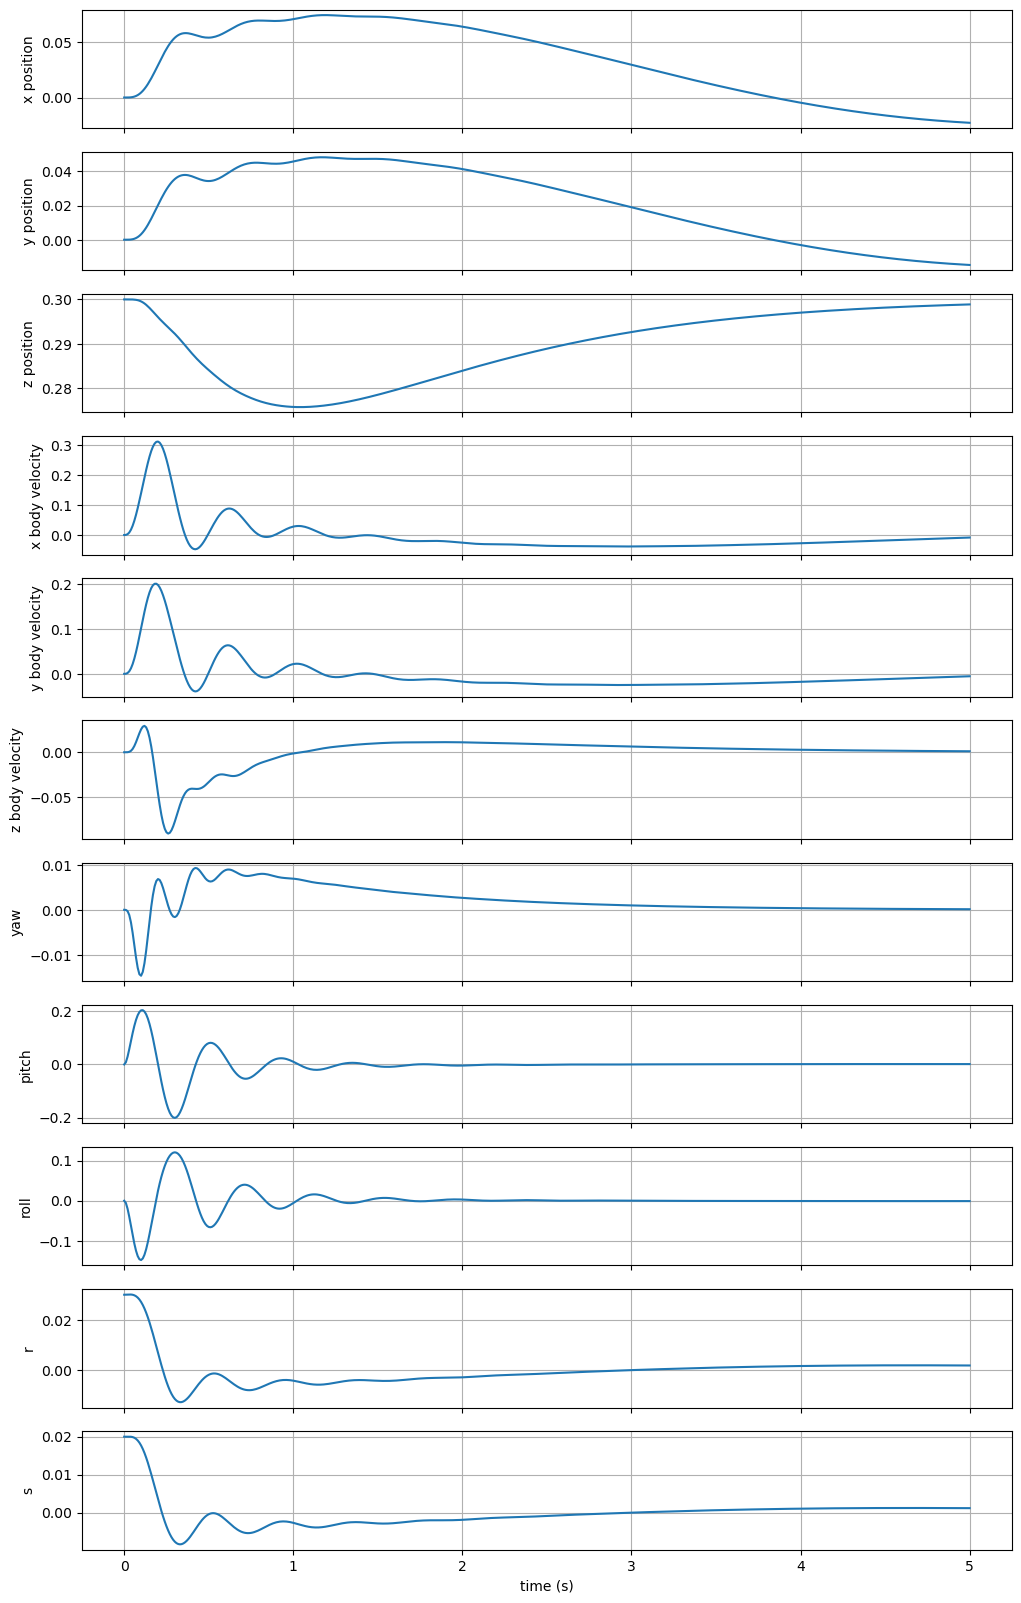

In [130]:
fig, (ax_o_x, ax_o_y, ax_o_z, ax_vx, ax_vy, ax_vz, ax_alpha, ax_beta, ax_gamma, ax_r_offset, ax_s_offset) = plt.subplots(11, 1, figsize=(12, 20), sharex=True)

# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

ax_o_x.plot(times, state_data[:,0])
ax_o_x.set_ylabel('x position')
ax_o_y.plot(times, state_data[:,2])
ax_o_y.set_ylabel('y position')
ax_o_z.plot(times, state_data[:,4])
ax_o_z.set_ylabel('z position')
ax_vx.plot(times, state_data[:,1])
ax_vx.set_ylabel('x body velocity')
ax_vy.plot(times, state_data[:,3])
ax_vy.set_ylabel('y body velocity')
ax_vz.plot(times, state_data[:,5])
ax_vz.set_ylabel('z body velocity')
ax_alpha.plot(times, state_data[:,6])
ax_alpha.set_ylabel('yaw')
ax_beta.plot(times, state_data[:,7])
ax_beta.set_ylabel('pitch')
ax_gamma.plot(times, state_data[:,8])
ax_gamma.set_ylabel('roll')
ax_r_offset.plot(times, state_data[:,12])
ax_r_offset.set_ylabel('r')
ax_s_offset.plot(times, state_data[:,13])
ax_s_offset.set_ylabel('s')
ax_o_x.grid()
ax_o_y.grid()
ax_o_z.grid()
ax_vx.grid()
ax_vy.grid()
ax_vz.grid()
ax_alpha.grid()
ax_beta.grid()
ax_gamma.grid()
ax_r_offset.grid()
ax_s_offset.grid()
ax_s_offset.set_xlabel('time (s)')


Text(0.5, 0, 'Time')

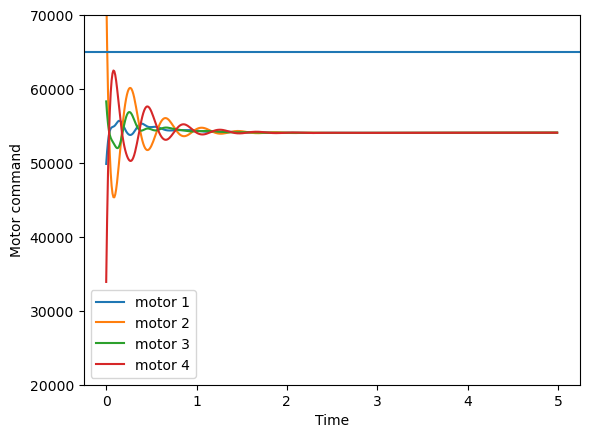

In [131]:
plt.plot(times[:-1], motor_commands[:-1,0], label="motor 1")
plt.plot(times[:-1], motor_commands[:-1,1], label="motor 2")
plt.plot(times[:-1], motor_commands[:-1,2], label="motor 3")
plt.plot(times[:-1], motor_commands[:-1,3], label="motor 4")
plt.axhline(65000)
plt.legend()
plt.ylim((20000, 70000))
plt.ylabel("Motor command")
plt.xlabel("Time")

### Save to Animation

In [132]:
# Write State Data and Timestamps to a csv for Animation

import os
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

record = []
for point in range(len(times)):
    cur_point = []
    cur_point.append(str(times[point]))
    cur_point.append(str(state_data[point,0])) #x-pos
    cur_point.append(str(state_data[point, 2])) #y-pos
    cur_point.append(str(state_data[point, 4])) #z-pos
    cur_point.append(str(state_data[point, 6])) #yaw
    cur_point.append(str(state_data[point, 7])) #pitch
    cur_point.append(str(state_data[point, 8])) #roll
    cur_point.append(str(state_data[point, 12])) #r
    cur_point.append(str(state_data[point, 13])) #s
    record.append(cur_point)

output_file = '3d-sim.csv'
with open(output_file, 'w') as f:
    f.write("time,x,y,z,yaw,pitch,roll,r,s\n")
    for point in record:
        f.write(f"{','.join(point)}\n")